# Filter Play V4

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = 24, 10
plt.style.use('dark_background')

In [16]:
# FUNCTIONS

def line(x):
    return 0

def gauss(x, m, s, A=1):
    return A* (np.exp(-(x-m)**2/(2*(s**2))))

def gauss_250(x, A):
    m = 250
    s   = 35
    return A * (np.exp(-(x-m)**2/(2*(s**2))))

def double_gauss(x,A1, A2, s1, s2, m1, m2):
    return gauss(x, A1, s1, m1) + gauss(x, A2, s2, m2)

def gen_noise(s, size=800):
    return s * np.random.randn(size)

def gen_gauss_signal(ns, m, s, A, size=800):
    noise = gen_noise(ns, size=size)
    sig      =  [gauss(x, m, s, A) for x in range(size)]
    return sig+noise

def gen_double_gauss_signal(ns, A1, A2, s1, s2, m1, m2, size = 800):
    noise = gen_noise(ns, size=size)
    sig      =  [double_gauss(x, A1, A2, s1, s2, m1, m2) for x in range(size)]
    return sig+noise, noise

def grid_it():
    plt.grid(True, which='both', linestyle='-', linewidth=0.75, color='gray')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='lightgray', linestyle='--', linewidth=0.25) 
    plt.legend()

def moving_average(x_array, y_array, window):

    new_x      = []
    avr_array = []
    for i in range(window, len(y_array) - window):

        new_x.append(x_array[i])
        
        val = 0
        for j in range(1, window):
            val+= y_array[i+j]
            val+=y_array[i-j]
        val+= y_array[i]
        avr_array.append(val/(window*2 +1))
    
    return new_x, avr_array

def chi_sq(obs, exp):
    size = len(obs)
    chi = 0
    for i in range(size):

        val = ( (obs[i] - exp[i])**2 )
        chi+=val
        
    return chi / size

def bkg_fit(data):

    fit_arr   = [line(x) for x in data[0]]
    chi          = chi_sq(data[1], fit_arr)
    
    return fit_arr, chi

def sig250_fit(data):

    popt, pcov = curve_fit(gauss_250, data[0], data[1])
    fit_arr         = [gauss_250(x, *popt) for x in data[0]]

    return popt


#    *   *   *    *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   * 


def bkg_model(x, A, s):
    return gauss(A,s,0)

def sig_model(x, A_bg, s_bg, A_sig, s_sig, m_sig):
    return bkg_model(x, A_bg, s_bg) + gauss(x, A_sig, s_sig, m_sig)


#    *   *   *    *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   * 

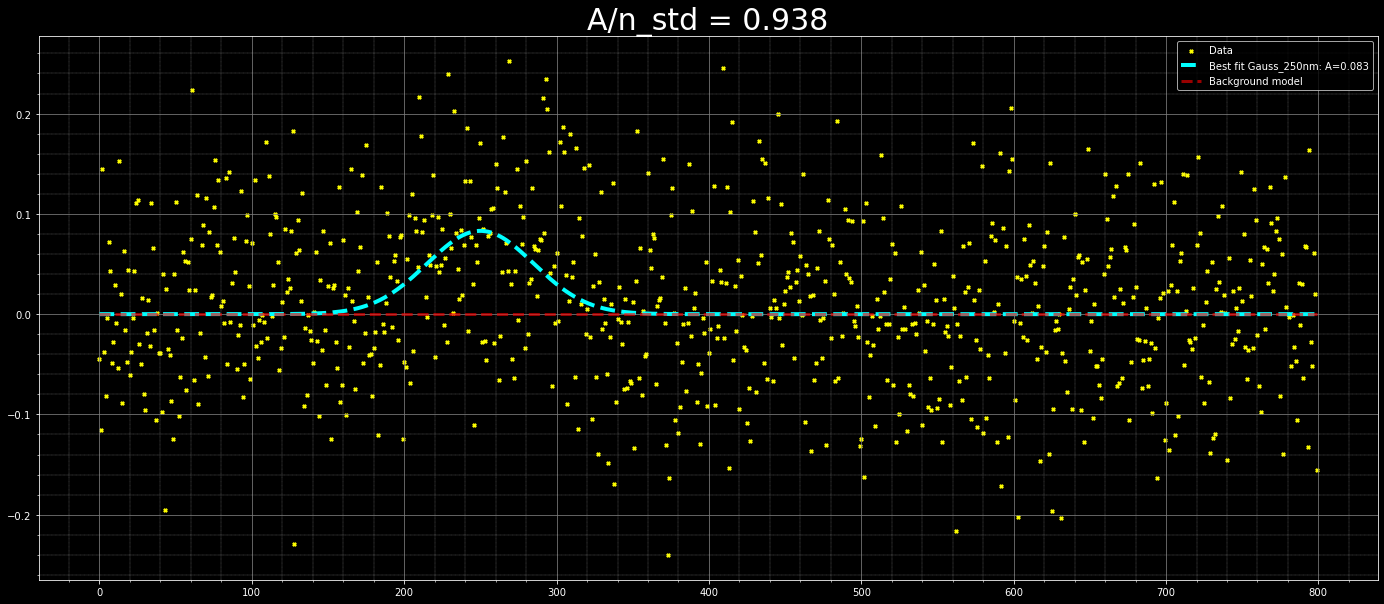

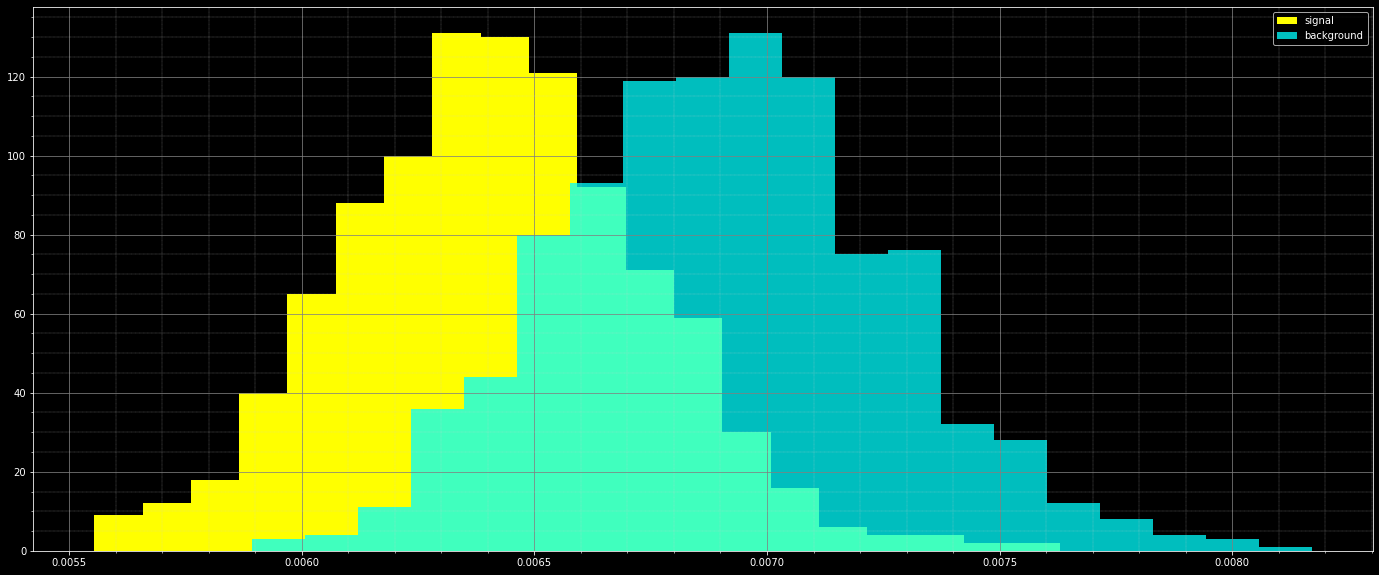

In [4]:
size = 800
wls = np.arange(0,size)

# signal parameters
A = 0.075; s = 40; m = 260

# noise parameters
n_mean = 0; n_std = 0.08


its = 1000

theta_sig_arr      = []
theta_noise_arr = []

for i in range(its):

    # generate signal
    sig_array      = [gauss(wl, m,s,A) for wl in wls ]
    noise_array = n_std * np.random.randn(size)
    
    data = [wls, sig_array+noise_array]
    
    # --- 
    
    popt_sig, theta_sig      = sig250_fit(data); 
    theta_sig_arr.append(theta_sig)
    
    line_arr, theta_noise = bkg_fit(data);
    theta_noise_arr.append(theta_noise)

plt.scatter(data[0], data[1], color='yellow', marker = 'X', label = 'Data', s=12)
plt.plot(data[0], gauss_250(data[0], *popt_sig), color = 'cyan', label = f'Best fit Gauss_250nm: A={np.round(popt_sig[0],3)}', linestyle = '--', linewidth = 4)
plt.plot(data[0], line_arr, color = 'red', label = 'Background model', linestyle = '--', linewidth = 3, alpha = 0.6)
plt.title(f'A/n_std = {np.round(A/n_std,3)}', fontsize = 30)
grid_it()
plt.show();

bins = 20
plt.hist(theta_sig_arr, bins = bins, color = 'yellow', label = 'signal')
plt.hist(theta_noise_arr, bins = bins, color = 'cyan', label = 'background', alpha = 0.75)
grid_it()

Two normal distributions should be fitted to the histograms -> this will give me a quantitative way to calculate an exact overlap and thus
the cutoff for the sensitivity.

---

## Likelihoods

In [53]:
m = 0; s = 0.08

m_sig = 250; s_sig = 35; A_sig = 0
m_model = 250;  s_model = 35 

its = 300

sigs = []
bgs = []
likes0 = []

for i in range(its):

    noise_array  = s * np.random.randn(800)
    data                =  gen_gauss_signal(s, m_sig, s_sig, A_sig, size=800)
    x_array           = np.arange(800)

    popt = sig250_fit([x_array, data])
    
    bg_like_arr = []
    sig_like_arr = []
    count = 0
    for elm in data:
        
        prob_val = np.log( gauss(elm, m, s) )
        bg_like_arr.append(prob_val)
    
        mean = m + gauss(count,m_model,s_model, popt)
        prob_val = np.log(gauss(elm, mean, s))
        sig_like_arr.append(prob_val)
    
        count+=1
    
    bg_like = np.sum(bg_like_arr)
    sig_like = np.sum(sig_like_arr)
    like        = bg_like/sig_like 
    
    sigs.append(sig_like)
    bgs.append(bg_like)
    likes0.append(like)

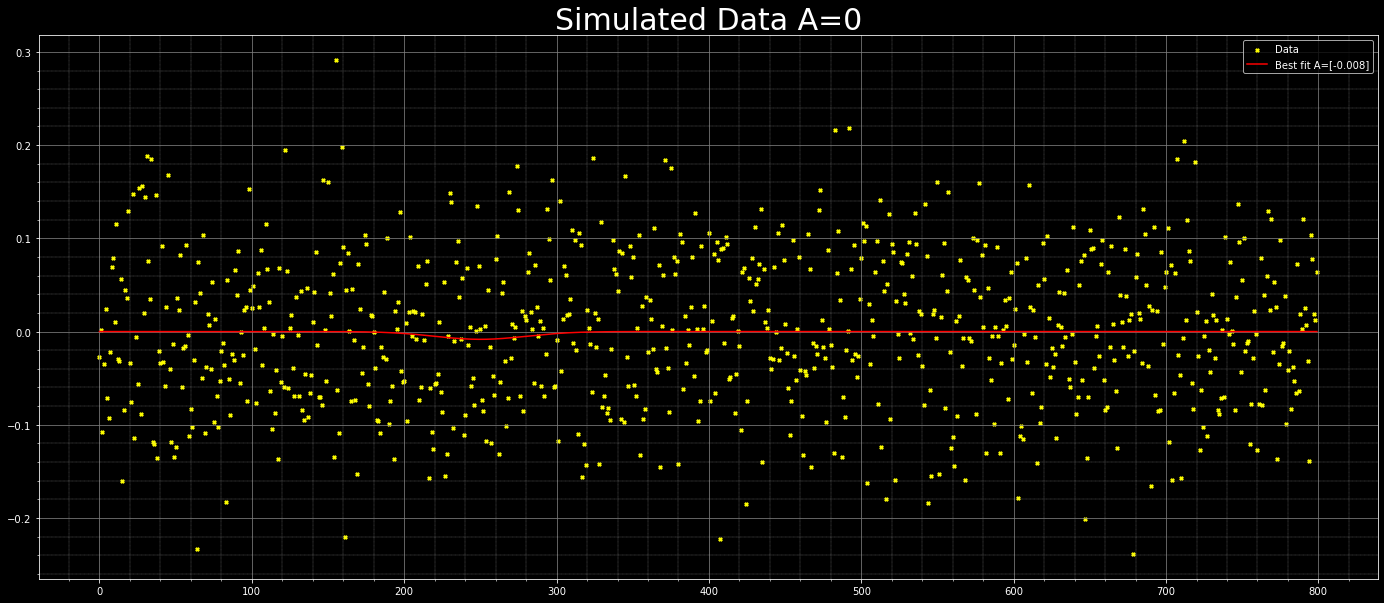

In [79]:
m = 0; s = 0.08

m_sig = 250; s_sig = 30; A_sig = 0

m_model = 250;  s_model = 30

its = 250

sigs = []
bgs = []
likes = []
a_arr = []

for i in range(its):

    noise_array  = s * np.random.randn(800)
    data                =  gen_gauss_signal(s, m_sig, s_sig, A_sig, size=800)
    x_array           = np.arange(800)

    popt = sig250_fit([x_array, data])
    a_arr.append(popt)
    
    bg_like_arr = []
    sig_like_arr = []
    count = 0
    for elm in data:
        
        prob_val = np.log( gauss(elm, m, s) )
        bg_like_arr.append(prob_val)
    
        mean = m + gauss(count,m_model,s_model, popt)
        prob_val = np.log(gauss(elm, mean, s))
        sig_like_arr.append(prob_val)

        
        count+=1
    
    bg_like = np.sum(bg_like_arr)
    sig_like = np.sum(sig_like_arr)
    like        = bg_like/sig_like 
    
    sigs.append(sig_like)
    bgs.append(bg_like)
    likes.append(like)


plt.scatter(x_array, data, color='yellow', marker = 'X', label = 'Data', s=12)
plt.plot(x_array, gauss(x_array, m_model, s_model, popt), color='red', label = f'Best fit A={np.round(popt, 3)}')
plt.title(f'Simulated Data A={A_sig}', fontsize=30)
grid_it()
plt.show()

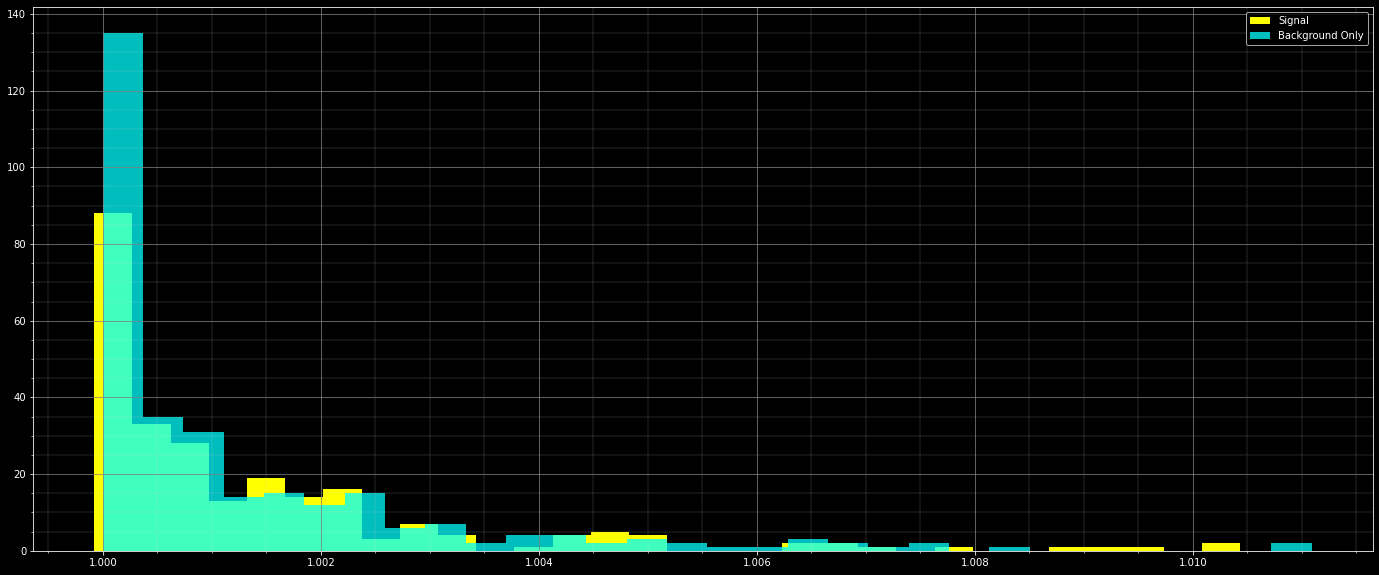

In [81]:
bins = 30
#plt.hist(sigs, bins=bins, label = 'Signal model', color = 'yellow');
#plt.hist(bgs, bins=bins, label = 'Background model', color='cyan', alpha = 0.75);
plt.hist(likes, bins=bins, label = 'Signal', color = 'yellow');
plt.hist(likes0, bins=bins, label = 'Background Only', color = 'cyan', alpha = 0.75);
#plt.title(f'A/noise: {np.round(A_sig/s,3)}', fontsize=30)
grid_it()

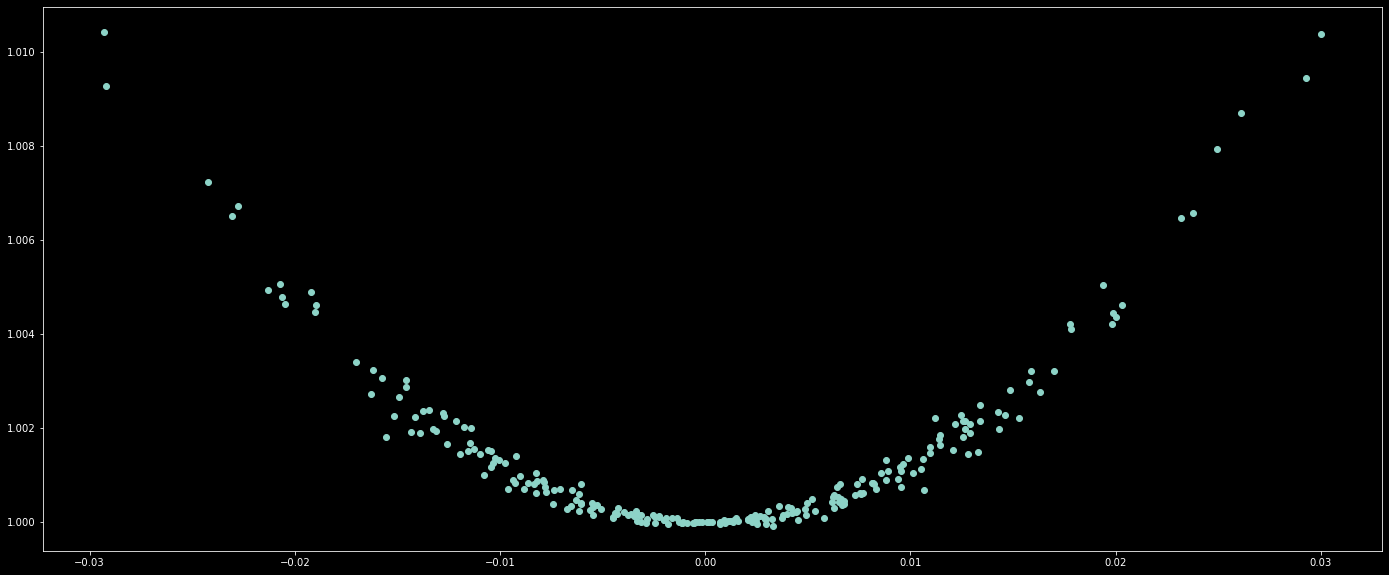

In [80]:
plt.scatter(a_arr, likes);